<a href="https://colab.research.google.com/github/zimine/Twitter-Text-Analysis/blob/main/twitter_text_analysis_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load packages

In [12]:
!pip install tweet-preprocessor
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import logging
import wget
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import preprocessor as p
import seaborn as sns
%matplotlib inline

## 2. Download dataset

In [3]:
print('Downloading dataset...')

# The URL for the dataset zip file
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Download the file 
wget.download(url)

# Unzip the dataset
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


# 3. EDA

In [11]:
# load the data into dataframe
df = pd.read_csv("./training.1600000.processed.noemoticon.csv", 
     names=['label', 'twitter_id', 'time', 'query', 'account', 'tweet'],
     encoding='latin-1')

# print the number of tweets
print('Number of tweets: {:,}\n'.format(df.shape[0]))

# sample 10 records from the data
df.sample(10)

Number of tweets: 1,600,000



,label,twitter_id,time,query,account,tweet
848063,4,1564732942,Mon Apr 20 04:43:41 PDT 2009,NO_QUERY,iyadb,trying tweetie OS application - it is cool i ...
1517817,4,2175886152,Mon Jun 15 02:16:57 PDT 2009,NO_QUERY,DailySpud,"@icanhascook ah, I know you'll be sad to leave..."
1040332,4,1956938066,Thu May 28 23:04:39 PDT 2009,NO_QUERY,virtual_diva,"hmm, i feel fairly accomplished. should i do m..."
194707,0,1970345287,Sat May 30 03:29:12 PDT 2009,NO_QUERY,Keels_90,@rach210 marathon isn't happening yet I'm just...
113338,0,1825788748,Sun May 17 06:50:37 PDT 2009,NO_QUERY,mcraddictal,@myhaloromance -cries- when i got out of walma...
1006797,4,1880643741,Fri May 22 01:58:58 PDT 2009,NO_QUERY,PembsDave,@hypnotized805 ..and a very Good Morning to yo...
1188135,4,1983276427,Sun May 31 12:50:49 PDT 2009,NO_QUERY,AgatheBauer,"@farocker Yeah, like it too"
1028981,4,1932701054,Tue May 26 22:01:30 PDT 2009,NO_QUERY,lukaMommy,@cherrythegreat naku mahal plane ticket. ;) ib...
112497,0,1825474521,Sun May 17 05:49:53 PDT 2009,NO_QUERY,Sharika007,PATD &amp; FOB &amp; BLINK182 in one concert!!...
1416750,4,2057475556,Sat Jun 06 13:04:29 PDT 2009,NO_QUERY,tweeteradder8,@fotensity Get 100 followers a day using www.t...


In [13]:
# number of unique id
print(df['twitter_id'].nunique())

# number of unique account
print(df['account'].nunique())

1598315
659775


In [14]:
# split the date column into week, month, day, time, timezone, year
df[['week','month','day','time','timezone','year']] = df['time'].str.split(" ", expand=True)

# check if time is normalized (if the timezone is the same)
df['timezone'].nunique()

1

In [16]:
df

,label,twitter_id,time,query,account,tweet,week,month,day,timezone,year
0,0,1467810369,22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon,Apr,06,PDT,2009
1,0,1467810672,22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Mon,Apr,06,PDT,2009
2,0,1467810917,22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Mon,Apr,06,PDT,2009
3,0,1467811184,22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Mon,Apr,06,PDT,2009
4,0,1467811193,22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Mon,Apr,06,PDT,2009
...,...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,08:40:49,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Tue,Jun,16,PDT,2009
1599996,4,2193601969,08:40:49,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Tue,Jun,16,PDT,2009
1599997,4,2193601991,08:40:49,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Tue,Jun,16,PDT,2009
1599998,4,2193602064,08:40:49,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Tue,Jun,16,PDT,2009


# 4. Extract mentions

In [17]:
# write a regex to match the pattern for mention
mentions_re = r'(?<=@)\w+'
# print the first tweet
print(df["tweet"].iloc[0])
"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# print the mention in the first tweet 
print(re.findall(mentions_re, df["tweet"].iloc[0]))

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['switchfoot']


In [18]:
# write a function to extract all of the mentions from each tweet
def extract_mentions(full_texts):
   mentions = pd.DataFrame(full_texts.str.lower().str.findall(mentions_re).explode().dropna())
   mentions.columns = ["mentions"]
   mentions = mentions.merge(df['label'], left_index=True, right_index=True, how='left')
   return mentions

# apply the function to the tweet column
mentions = extract_mentions(df['tweet'])
mentions['mentions'].value_counts()[:5]

mileycyrus       4580
tommcfly         3904
ddlovato         3474
jonasbrothers    2384
davidarchie      1386
Name: mentions, dtype: int64

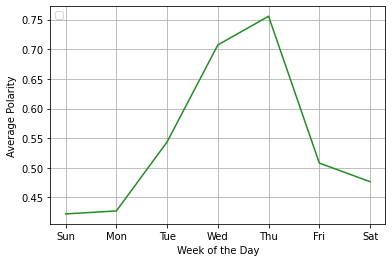

In [28]:
# pivot the table
by_week = pd.pivot_table(df, values='year', index=['label'], columns=['week'], aggfunc='count')
cols = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
by_week[cols] = by_week[cols] / by_week[cols].sum()
by_week = by_week.transpose().reindex(cols)
by_week.index.name = None
by_week.columns.name = None

# plot the proportion of tweets with negative polarity across the whole week
sns.lineplot(data=by_week, x=by_week.index, y=0, color='forestgreen')
plt.title('')
plt.legend(loc=2)
plt.xlabel("Week of the Day")
plt.ylabel("Average Polarity")
plt.grid()
plt.show()